## Analysing all-time olympic games medal

- [Introduction & preprocessing](#introduction-and-preprocessing)
- [Stacked bar chart](#stacked-bar-chart)
- [Bubble chart](#bubble-chart)

***

### Introduction

The following notebook uses the olympics dataset [olympics.csv](/assets/olympics.csv), which was derived from the Wikipedia entry on [All Time Olympic Games Medals](https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table), as of the 2016 Summer Olympics and 2018 Winter Olympics, and all changes in medal standings due to doping cases and medal redistributions up to and including 25 November 2020 are taken into account.  
*Data queried on March 18th, 2021.*
***



Read the csv file containing the dataset (the result is a DataFrame). Then perform data cleaning and preprocessing operations to get a more readable and practical format of the DataFrame, to be used later.

In [10]:
import pandas as pd
df = pd.read_csv("olympics.csv",index_col=0,skiprows=1, encoding='latin_1')

for col in df.columns:    # clean the lables of the raw data
    if col[:2]=="01":
        df.rename(columns={col:"Gold"+col[4:]}, inplace=True)
    if col[:2]=="02":
        df.rename(columns={col:"Silver"+col[4:]}, inplace=True)
    if col[:2]=="03":
        df.rename(columns={col:"Bronze"+col[4:]}, inplace=True)
    if col[:1]=="№":
        df.rename(columns={col:"#"+col[1:]}, inplace=True)

names_ids = df.index.str.split('\s\(')    # split the index by '('

df.index = names_ids.str[0]    # the [0] element is the country name (will be the new index) 

df['ID'] = names_ids.str[1].str[:3]    # the [1] element is the abbreviation or ID (take first 3 characters)

spare_df = df.copy()
df = df.drop('Totals')    # remove the row with label 'Totals'

***
Get the top ten countries that have the most medals in the summer and winter games.

In [11]:
most_medals = df['Combined total'].nlargest(10).index

***
### Stacked bar chart
In this cell, we use [**matplotlib**](http://matplotlib.org/) to visualize stacked bar charts representing the top ten countries in terms of total number of medals in the winter and summer games.
***

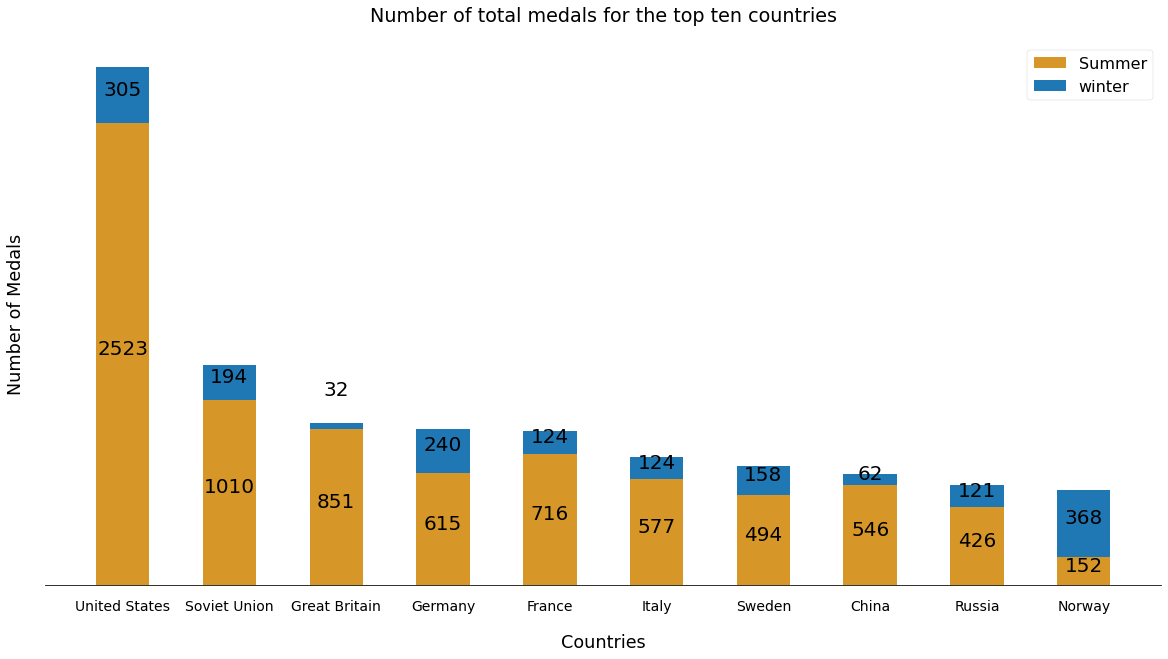

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline 

# get necessary pandas series 
summer_medals = df.loc[most_medals, ['Total']]['Total']
winter_medals = df.loc[most_medals, ['Total.1']]['Total.1']

fig = plt.figure(figsize=(20, 10)) # create a figure object

# context manager for temporary styling
with plt.style.context(('seaborn-poster', {'xtick.labelsize' : 14, 'axes.labelpad':20 , 'axes.titlepad' : 20,
                        'axes.spines.top' : False, 'axes.spines.right' : False, 'axes.spines.left' : False} )): 
    # create the bar plots
    bar_list = [plt.bar(range(len(most_medals)), summer_medals, width = 0.5 ,color='#d69728', 
                        tick_label = most_medals, label = 'Summer'),    
         plt.bar(range(len(most_medals)), winter_medals, width = 0.5 , bottom = summer_medals , 
                 tick_label = most_medals, label = 'winter')]
    ax = plt.gca()
    ax.set_ylabel('Number of Medals')
    ax.set_xlabel('Countries')
    ax.set_title('Number of total medals for the top ten countries')
    ax.tick_params(bottom=False, left=False, labelleft=False)
    
    # attach text label for each bar displaying its value
    for i in bar_list:
        for bar in i:
            height = bar.get_height()
            bottom = bar.get_y()
            if height < 50:
                y = 0.5*height+bottom*1.20
            else:
                y = 0.5*height+bottom
            plt.gca().text(bar.get_x() + bar.get_width()/2, y, str(int(height)),
                 ha='center', color='black', fontsize=20)
    plt.legend()

# save the plot as a png file. you can change the file format to pdf or any supported extension (comment out to use)
#fig.savefig("totalmedals.png", dpi=150)

***
### Bubble chart
This chart is an example of a visualization that can be created to help understand the data. This is a bubble chart showing the value of *adjusted gold medals* (#total gold/ #total games) Vs. the *rank* with reference to the number of total medals won.  

The **size** of the bubble corresponds to an *adjusted value of total medals* (#total medals/ #total games) won, and the **color** corresponds to the geolocation (European or non-European) or current status (red: no longer exists).
***

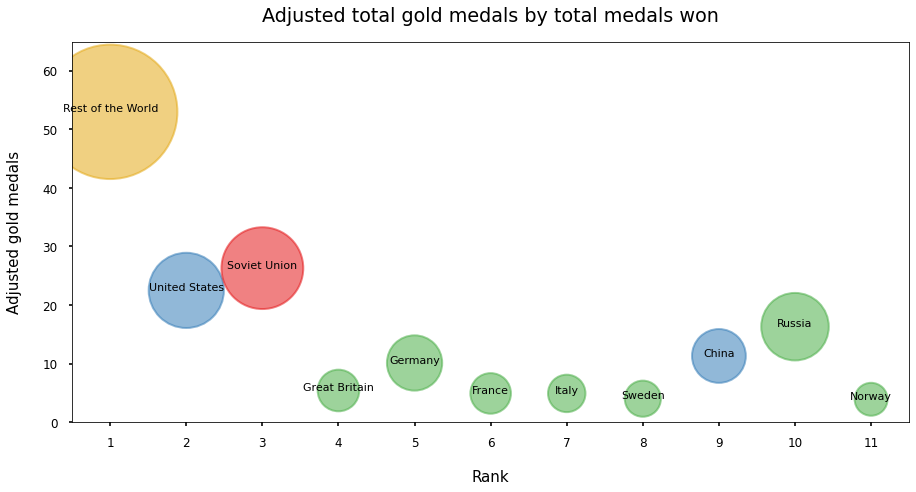

In [16]:
top_medals = spare_df['Combined total'].nlargest(11).index
bubble_df = spare_df.loc[top_medals].drop('ID', axis=1) # dataframe for top 11 winners

# to eliminate overlapping medals' count
sum_topcoun = bubble_df[1:][bubble_df.columns[~bubble_df.columns.str.contains('#')]].sum()
for col in bubble_df.columns:
    if col  in sum_topcoun.index:        
        bubble_df.loc['Totals'][col] -= sum_topcoun[col] 

bubble_df = bubble_df.rename(index={'Totals':'Rest of the World'})

# create 2 new columns with their respective data
bubble_df['adjusted_cgold'] = (bubble_df['Gold.2'].div(bubble_df['# Combined Games'])).apply(lambda x: float('%.1f'%x))
bubble_df['Rank'] = range(1,len(bubble_df.index)+1)

# chart creation and styling
with plt.style.context(('seaborn-poster', {'xtick.labelsize' :12, 'ytick.labelsize':12,'axes.labelpad':20 ,
                                           'axes.titlepad' : 20,'axes.labelsize':15} )):
    ax2 = bubble_df.plot(x='Rank', y='adjusted_cgold', kind='scatter',
                    c=['#e4aa1a','#377eb8','#e41a1c','#4daf4a','#4daf4a','#4daf4a','#4daf4a','#4daf4a', 
                    '#377eb8','#4daf4a','#4daf4a'], linewidths=2 , 
                    xticks=range(1,len(bubble_df.index)+1), 
                         s=(bubble_df['Combined total'].div(bubble_df['# Combined Games']))*100, alpha=.55, figsize=[15,7])
    ax2.set_ylim(0,65)
    ax2.set_title('Adjusted total gold medals by total medals won')
    ax2.set_ylabel('Adjusted gold medals')
    for i, txt in enumerate(bubble_df.index):    # add labels inside each bubble
        ax2.annotate(txt, [bubble_df['Rank'][i], bubble_df['adjusted_cgold'][i]], ha='center',fontsize=11)

#plt.savefig("cgold.png", dpi=150)

***
This chart shows that the United States has the most number of total medals in summer and winter games as indicated by the x-axis (Rank). Norway has the least number of combined medals among the top ten.

Based on the values of *adjusted gold medals* represented by the y-axis, the Soviet Union won the most gold medals relative to the number of olympic games in which they participated, followed by the US and Russia respectively.

The sizes of bubbles suggest that the top 3 countries that won *most medals* relative to the number of games they were part of, are respectively, the Soviet Union, the US and Russia.

To put it in perspective by comparing France and China, the latter won *less* total medals overall (position on x-axis). But taking into account the number of olympic games played, China *did* win more gold medals (position on y-axis) and total medals (bubble-size) .